# Workshop 3: Network analysis

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia  
**Authors**: Alicia Arévalo Robinson  
**Docker image**: alarevalo/network_analysis  

This workshop introduces the fundamentals of network analysis using real-world street data. Network properties such as street types, lengths, and connectivity are studied in order to calculate and visualize shortest paths between locations. These exercises also include exploring spatial relationships, like identifying buildings near a route.


## 0. Requirements 🗒️

### Import modules

In [32]:
import networkx as nx
import osmnx
import shapely.geometry
import geopandas

import contextily
import matplotlib.pyplot
import matplotlib.pyplot as plt

import pathlib

import math
import myst_nb

### Creating a graph

Use `networkx` library to create, manipulate and visualize graphs.

[1, 2, 3]
[(1, 2)]


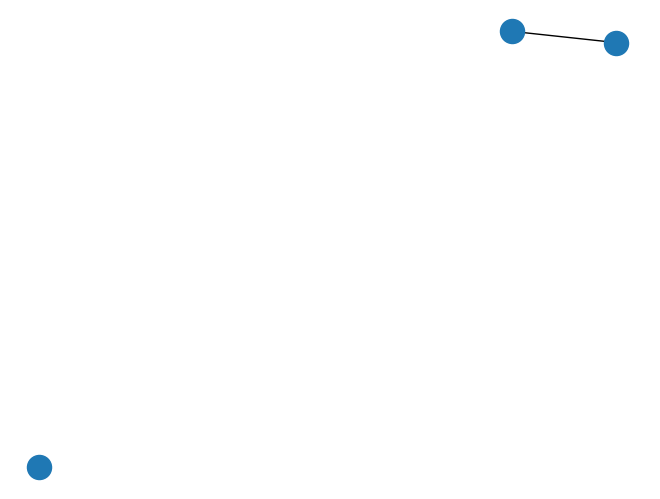

In [33]:
# Create an empty, undirected graph
G = nx.Graph()

# Add nodes and an edge
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspect nodes and edges
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Attach metadata
G.nodes[1]["label"] = "blue"

nx.draw(G)

## 1. Obtain a routable network 🕸️

Use `osmnx.graph_from_place()` to download **OpenStreetMap** data that represents the street network  

The selected place for this practice is *Teusaquillo* locality and the network_type is *walk*

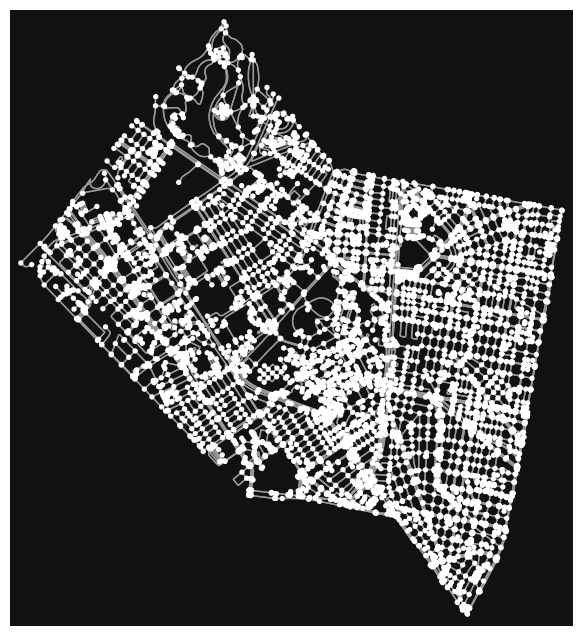

In [34]:
PLACE_NAME = "Teusaquillo, Bogotá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="walk"
)
figure, ax = osmnx.plot_graph(graph)

There are cases where the shortest path is outside the defined area of interest. To guarantee a real calculation, we can expand our area of interest by applying a buffer of 200 m to the polygon.

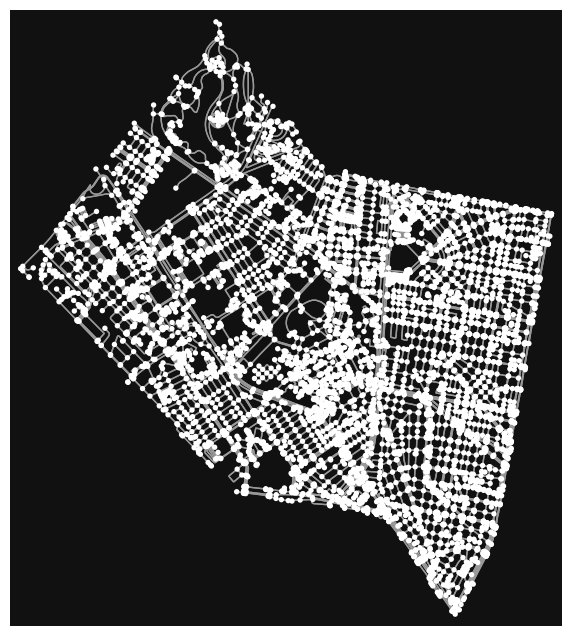

In [35]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="walk"
)

fig, ax = osmnx.plot_graph(graph)

### 1.1. Data overview

Convert the network into a GeoDataFrame to take a look if the attributes assigned to the
nodes and edges. `osmnx.graph_to_gdfs()` function is used for this.

In [36]:
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges

osmid  \
u           v           key                                         
253762003   500959293   0                                24350411   
            7607115142  0                                24350411   
            264153961   0                                89574149   
            500959410   0                                89574149   
253762008   500959410   0                                89574149   
...                                                           ...   
12887032195 11946116560 0                               834758693   
            12887032196 0    [1392159379, 1392159382, 1392159375]   
12887032196 12887032190 0                              1392159373   
            12887032184 0                              1392159373   
            12887032195 0    [1392159379, 1392159382, 1392159375]   

                                         highway lanes        name  oneway  \
u           v           key                                                  
253762003   500959293   0            residential     2  Carrera 24   False   
            7607115142  0            residential     2  Carrera 24   False   
            264153961   0            residential     2    Calle 27   False   
            500959410   0            residential     2    Calle 27   False   
253762008   500959410   0            residential     2    Calle 27   False   
...                                          ...   ...         ...     ...   
12887032195 11946116560 0                footway   NaN         NaN   False   
            12887032196 0    [corridor, footway]   NaN         NaN   False   
12887032196 12887032190 0                footway   NaN         NaN   False   
            12887032184 0                footway   NaN         NaN   False   
            12887032195 0    [corridor, footway]   NaN         NaN   False   

                            reversed      length maxspeed  \
u           v           key                                 
253762003   500959293   0      False   54.439641      NaN   
            7607115142  0       True   83.514286      NaN   
            264153961   0      False   91.009857       30   
            500959410   0       True   85.457771       30   
253762008   500959410   0      False   89.638377       30   
...                              ...         ...      ...   
12887032195 11946116560 0       True   10.490638      NaN   
            12887032196 0       True  328.414669      NaN   
12887032196 12887032190 0      False    7.368699      NaN   
            12887032184 0       True   12.978797      NaN   
            12887032195 0      False  328.414669      NaN   

                                                                      geometry  \
u           v           key                                                      
253762003   500959293   0          LINESTRING (-74.077 4.6225, -74.076 4.6227)   
            7607115142  0          LINESTRING (-74.077 4.6225, -74.077 4.6221)   
            264153961   0          LINESTRING (-74.077 4.6225, -74.076 4.6218)   
            500959410   0          LINESTRING (-74.077 4.6225, -74.077 4.6231)   
253762008   500959410   0          LINESTRING (-74.078 4.6238, -74.077 4.6231)   
...                                                                        ...   
12887032195 11946116560 0            LINESTRING (-74.07 4.6202, -74.07 4.6203)   
            12887032196 0    LINESTRING (-74.07 4.6202, -74.07 4.6202, -74....   
12887032196 12887032190 0          LINESTRING (-74.072 4.6176, -74.072 4.6176)   
            12887032184 0          LINESTRING (-74.072 4.6176, -74.072 4.6177)   
            12887032195 0    LINESTRING (-74.072 4.6176, -74.072 4.6176, -7...   

                            bridge access service width junction area tunnel  
u           v           key                                                   
253762003   500959293   0      NaN    NaN     NaN   NaN      NaN  NaN    NaN  
            7607115142  0      NaN    NaN     NaN

Types of highway our network has

In [37]:
edges["highway"].value_counts()

highway
footway                               10248
residential                            5376
service                                2672
tertiary                               1922
secondary                              1894
unclassified                            172
trunk                                   170
[residential, footway]                   88
trunk_link                               80
primary_link                             66
pedestrian                               54
secondary_link                           52
primary                                  50
[corridor, footway]                      50
track                                    32
tertiary_link                            30
[service, footway]                       26
[steps, footway]                         20
steps                                    18
[footway, steps]                         18
path                                     12
[service, residential]                    8
[secondary, tertiary]   

### 1.2. Transform to projected reference system

The network data uses the WGS84 (EPSG:4326) coordinate reference system (CRS), which is geographic. This means that distances are measured in degrees and areas in square degrees, which isn’t ideal for network analysis tasks like calculating shortest paths. With `osmnx.project_graph()` function is possible to input our graph and set to it a CRS.

In [38]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 
# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)
nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 2. Analysing network properties

### 2.1 Basic descriptive geometric and topological measures

OSMNx offer a function (osmnx.stats.basic_stats()) to calculate basic descriptive geometric and topological measures of a graph.

| **Key**                        | **Meaning**                                                                 |
|-------------------------------|------------------------------------------------------------------------------|
| `n`                           | Number of nodes (intersections, dead-ends)                                  |
| `m`                           | Number of edges (street segments)                                           |
| `k_avg`                       | Average node degree (connections per node)                                  |
| `edge_length_total`           | Total length of all edges (meters)                                          |
| `edge_length_avg`             | Average edge length (meters)                                                |
| `streets_per_node_avg`        | Average number of streets per node                                          |
| `streets_per_node_counts`     | Number of nodes with 1, 3, 4, etc. streets attached                         |
| `streets_per_node_proportions`| Proportion of nodes with each street count                                  |
| `intersection_count`          | Number of intersections                                                     |
| `street_length_total`         | Total length of undirected streets (meters)                                 |
| `street_segment_count`        | Number of undirected street segments                                        |
| `street_length_avg`           | Average undirected street segment length (meters)                           |
| `circuity_avg`                | Average circuity (edge length / straight-line distance)                     |
| `self_loop_proportion`        | Proportion of edges that are self-loops                                     |


In [39]:
osmnx.basic_stats(graph)

{'n': 7484,
 'm': 23092,
 'k_avg': 6.17103153393907,
 'edge_length_total': 1047350.5286887941,
 'edge_length_avg': 45.355557279092075,
 'streets_per_node_avg': 3.1122394441475145,
 'streets_per_node_counts': {0: 0,
  1: 984,
  2: 0,
  3: 3727,
  4: 2739,
  5: 33,
  6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.13148049171566006,
  2: 0.0,
  3: 0.4979957242116515,
  4: 0.3659807589524319,
  5: 0.0044094067343666485,
  6: 0.00013361838588989844},
 'intersection_count': 6500,
 'street_length_total': 523675.26434439706,
 'street_segment_count': 11546,
 'street_length_avg': 45.355557279092075,
 'circuity_avg': 1.0434017694611852,
 'self_loop_proportion': 0.0009527108955482419}

This does not yet yield all interesting characteristics of our network, as
OSMnx does not automatically take the area covered by the network into
consideration. We can do that manually, by, first, delineating the [complex
hull](https://en.wikipedia.org/wiki/Convex_hull) of the network (of an ’unary’
union of all its features), and then, second, computing the area of this hull.

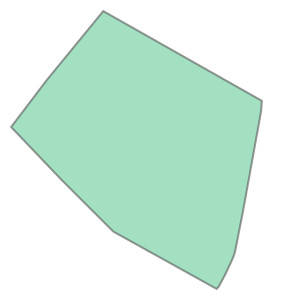

In [40]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [41]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 7484,
 'm': 23092,
 'k_avg': 6.17103153393907,
 'edge_length_total': 1047350.5286887941,
 'edge_length_avg': 45.355557279092075,
 'streets_per_node_avg': 3.1122394441475145,
 'streets_per_node_counts': {0: 0,
  1: 984,
  2: 0,
  3: 3727,
  4: 2739,
  5: 33,
  6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.13148049171566006,
  2: 0.0,
  3: 0.4979957242116515,
  4: 0.3659807589524319,
  5: 0.0044094067343666485,
  6: 0.00013361838588989844},
 'intersection_count': 6500,
 'street_length_total': 523675.26434439706,
 'street_segment_count': 11546,
 'street_length_avg': 45.355557279092075,
 'circuity_avg': 1.0434017694611852,
 'self_loop_proportion': 0.0009527108955482419,
 'node_density_km': 453.1001569445918,
 'intersection_density_km': 393.5263255130741,
 'edge_density_km': 63409.23155062718,
 'street_density_km': 31704.61577531359}

### 2.2 Exploring street attributes

Calculate the total length of streets classified as `residential`, `primary`, and `secondary`

In [42]:
selected_classes = ['residential', 'primary', 'secondary']
total_lengths = edges[edges['highway'].isin(selected_classes)].groupby('highway')['length'].sum()
print("Total lengths (meters):")
print(total_lengths)

Total lengths (meters):
highway
primary          4594.607944
residential    257076.923992
secondary       87498.331288
Name: length, dtype: float64


Compare the mean length for each class

In [43]:
mean_lengths = edges[edges['highway'].isin(selected_classes)].groupby('highway')['length'].mean()
print("Mean lengths (meters):")
print(mean_lengths)

Mean lengths (meters):
highway
primary        91.892159
residential    47.819368
secondary      46.197641
Name: length, dtype: float64


Visualise the five longest street classes in a bar chart

Text(0, 0.5, 'Total Length (meters)')

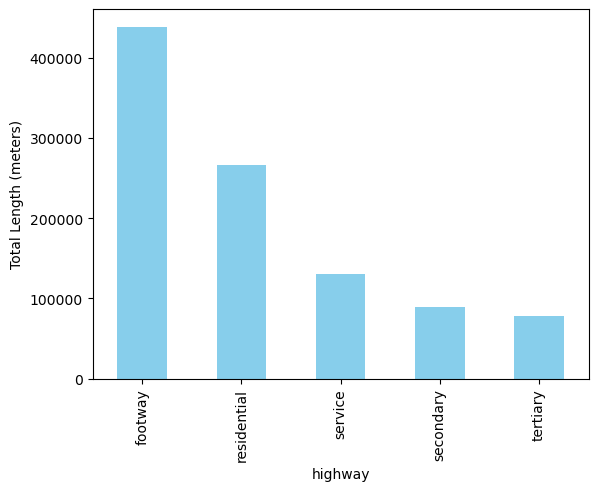

In [44]:
edges_exploded = edges.explode('highway')
top5 = edges_exploded.groupby('highway')['length'].sum().sort_values(ascending=False).head(5)
top5.plot(kind='bar', color='skyblue')
plt.ylabel('Total Length (meters)')

Save (or "glue") computed values

In [45]:
#Saves the value of stats["node_density_km"] (rounded to 1 decimal) 
myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))

#Saves the value of stats["edge_length_total"] (converted from meters to kilometers and rounded down) 
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

453.1

1047

## 3. Shortest path analysis

### 3.1 Define origin and destination points

This analysis consists of calculating the shortest path between two points. The origin point is *Corferias, Bogotá* and the destination is *Parkway, Bogotá*.

In [46]:
origin = (
    osmnx.geocode_to_gdf("corferias, bogota")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("parkway, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

We now have `shapely.geometry.Point`s representing the origin and destination
locations for our network analysis. 



### 3.2. Nearest node

Use the `osmnx.nearest_nodes()` function to find our points of interest in the network and then calculate the shortest route.

In [47]:
# For origin point
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
# For destination point
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

### 3.3. Routing

To calculate the shortest route, we will use two algorithms: Dijkstra and A*.

- **Dijkstra’s Algorithm** finds the shortest path between two nodes in a graph by exploring all possible paths and always choosing the path with the lowest total cost so far. It guarantees the shortest path but can be slower for large networks.

- **A * Algorithm** also finds the shortest path but uses a heuristic to estimate the remaining distance to the destination. This allows it to focus the search and often find the shortest path more quickly than Dijkstra’s algorithm, especially in spatial networks.

#### **Dijkstra Algorithm**


To find the shortest path, we will use `nx.shortest_path` functions and insert the parameter *method="dijkstra"*  
The function accepts three mandatory parameters: a graph, an origin node id, and
a destination node id, and two optional parameters: `weight` can be set to
consider a different *cost impedance* than the length of the route, and `cpus`
controls parallel computation of many routes.

In [48]:
# Find the shortest path between origin and destination
dijkstra_route = nx.shortest_path(graph, origin_node_id, destination_node_id, weight="length", method="dijkstra")
dijkstra_route

[9435421106,
 7730318309,
 9435421189,
 9409664910,
 9435421458,
 9411808930,
 9411808926,
 9371185970,
 10276682223,
 10276682222,
 10276682239,
 9379706792,
 269425310,
 269425307,
 10276501847,
 263066267,
 263066270,
 9362410976,
 8693345010,
 10276501859,
 269425265,
 10276682242,
 269425271,
 10276682245,
 269425280,
 5101344911,
 7513019561,
 7490441077,
 7495126738,
 7490441070,
 7490441069,
 7490441064,
 2333232388,
 7607139463,
 7607139465,
 1940986393,
 1940986396,
 1940986399,
 1940986402,
 9377896658,
 264154415,
 264154416,
 264154417,
 10090683303,
 264154418,
 264154420,
 10090985223,
 6371463758,
 5118943169,
 264154396,
 264154392,
 3978836109,
 263544150,
 3730129185,
 11976148422,
 3977979731]

As a result we get a list of all the nodes that are along the shortest path. 

To plot the shortest path, use `plot_graph_route()` function

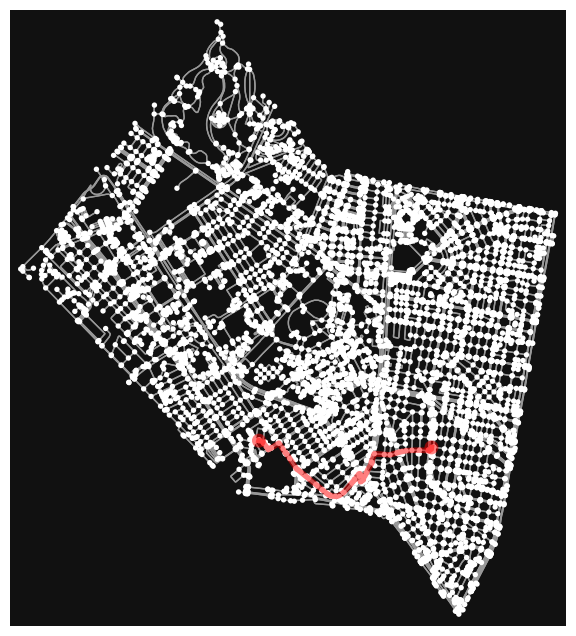

In [49]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, dijkstra_route)

#### **A * Algorithm**

Calculate shortest distance using `nx.astar_path` function

In [50]:
astar_route = nx.astar_path(graph, origin_node_id, destination_node_id, weight="length")
astar_route

[9435421106,
 7730318309,
 9435421189,
 9409664910,
 9435421458,
 9411808930,
 9411808926,
 9371185970,
 10276682223,
 10276682222,
 10276682239,
 9379706792,
 269425310,
 269425307,
 10276501847,
 263066267,
 263066270,
 9362410976,
 8693345010,
 10276501859,
 269425265,
 10276682242,
 269425271,
 10276682245,
 269425280,
 5101344911,
 7513019561,
 7490441077,
 7495126738,
 7490441070,
 7490441069,
 7490441064,
 2333232388,
 7607139463,
 7607139465,
 1940986393,
 1940986396,
 1940986399,
 1940986402,
 9377896658,
 264154415,
 264154416,
 264154417,
 10090683303,
 264154418,
 264154420,
 10090985223,
 6371463758,
 5118943169,
 264154396,
 264154392,
 3978836109,
 263544150,
 3730129185,
 11976148422,
 3977979731]

Plot the shortest path

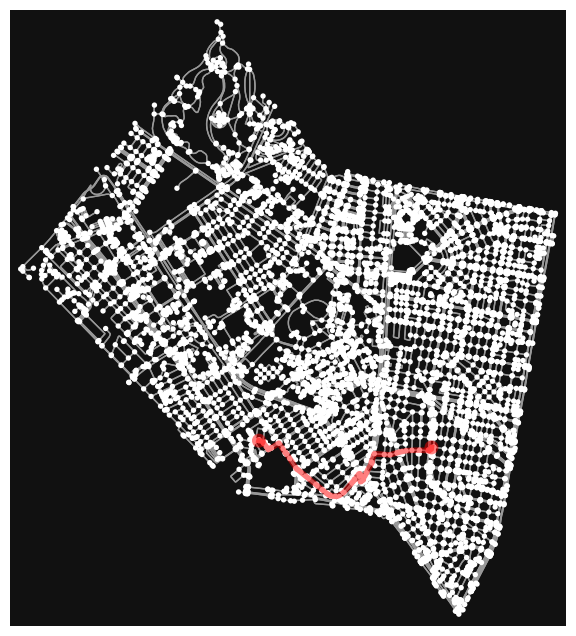

In [51]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, astar_route)

#### Comparison of algorithms

Validate if the routes gotten are equal

In [61]:
if dijkstra_route == astar_route:
    print(f"Dijkstra and A* routes are equal")

Dijkstra and A* routes are equal


Use `path_weight` to calculate the total length of the shortest path

In [60]:
# For Dijkstra algorithm
dijkstra_length = nx.path_weight(graph, dijkstra_route, weight="length")
print(f"Total route length with Dijkstra: {dijkstra_length:} meters")

# For A* algorithm
astar_length = nx.path_weight(graph, astar_route, weight="length")
print(f"Total route length with A*: {astar_length:} meters")

Total route length with Dijkstra: 2342.1335183209894 meters
Total route length with A*: 2342.1335183209894 meters


Using both algorihtms we get the same shortest path with a total route length of 2.34 km

### 3.4. Alternative routes

1. **Calculate** a second route that avoids `motorway` and `trunk` streets.  
2. **Compare** its length with the original shortest route.  
3. **Discuss** in one sentence why constrained routes can be useful for certin users.

> 💡 You can filter `edges` before building a sub-graph or use `osmnx.utils_graph.get_route_edge_attributes`.

In [52]:
edges

osmid  \
u           v           key                                         
253762003   500959293   0                                24350411   
            7607115142  0                                24350411   
            264153961   0                                89574149   
            500959410   0                                89574149   
500959293   10090985240 0                                24350411   
...                                                           ...   
12887032190 12887032196 0                              1392159373   
            12887032189 0    [1392159380, 1392159381, 1392159374]   
12887032196 12887032190 0                              1392159373   
            12887032184 0                              1392159373   
            12887032195 0    [1392159379, 1392159382, 1392159375]   

                                         highway lanes        name  oneway  \
u           v           key                                                  
253762003   500959293   0            residential     2  Carrera 24   False   
            7607115142  0            residential     2  Carrera 24   False   
            264153961   0            residential     2    Calle 27   False   
            500959410   0            residential     2    Calle 27   False   
500959293   10090985240 0            residential     2  Carrera 24   False   
...                                          ...   ...         ...     ...   
12887032190 12887032196 0                footway   NaN         NaN   False   
            12887032189 0    [corridor, footway]   NaN         NaN   False   
12887032196 12887032190 0                footway   NaN         NaN   False   
            12887032184 0                footway   NaN         NaN   False   
            12887032195 0    [corridor, footway]   NaN         NaN   False   

                            reversed      length maxspeed  \
u           v           key                                 
253762003   500959293   0      False   54.439641      NaN   
            7607115142  0       True   83.514286      NaN   
            264153961   0      False   91.009857       30   
            500959410   0       True   85.457771       30   
500959293   10090985240 0      False   47.759220      NaN   
...                              ...         ...      ...   
12887032190 12887032196 0       True    7.368699      NaN   
            12887032189 0      False  332.238743      NaN   
12887032196 12887032190 0      False    7.368699      NaN   
            12887032184 0       True   12.978797      NaN   
            12887032195 0      False  328.414669      NaN   

                                                                      geometry  \
u           v           key                                                      
253762003   500959293   0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
            7607115142  0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
            264153961   0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
            500959410   0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
500959293   10090985240 0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
...                                                                        ...   
12887032190 12887032196 0      LINESTRING (6.03e+05 5.1e+05, 6.03e+05 5.1e+05)   
            12887032189 0    LINESTRING (6.03e+05 5.1e+05, 6.03e+05 5.1e+05...   
12887032196 12887032190 0      LINESTRING (6.03e+05 5.1e+05, 6.03e+05 5.1e+05)   
            12887032184 0      LINESTRING (6.03e+05 5.1e+05, 6.03e+05 5.1e+05)   
            12887032195 0    LINESTRING (6.03e+05 5.1e+05, 6.03e+05 5.1e+05...   

                            tunnel service bridge access width junction area  
u           v           key                                                   
253762003   500959293   0      NaN     NaN    NaN    NaN   NaN      NaN  NaN  
            7607115142  0      NaN     NaN    NaN

In [53]:
# Exclude edges with 'motorway' or 'trunk' in the 'highway' column
edges_no_motorway = edges[~edges['highway'].isin(['motorway', 'trunk'])]

# Convert to GeoDataFrame
#edges_no_motorway = osmnx.graph_to_gdfs(edges_no_motorway, nodes=False, edges=True)

# Create a new graph without these edges
edges_no_motorway = nx.edge_subgraph(edges_no_motorway, edges_no_motorway.index)

# Now you can use these nodes for shortest path calculation
route_no_motorway = nx.shortest_path(edges_no_motorway, origin_node_id, destination_node_id, weight='length')

# Calculate the shortest path (replace 'origin' and 'destination' with your node IDs)
route_no_motorway = nx.shortest_path(edges_no_motorway, origin, destination, weight='length')
length_no_motorway = nx.shortest_path_length(edges_no_motorway, origin, destination, weight='length')

AttributeError: 'GeoDataFrame' object has no attribute 'is_multigraph'

In [ ]:
print(origin in edges_no_motorway.nodes)
print(destination in edges_no_motorway.nodes)

False
False


In [ ]:
edges_no_motorway

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable
information for many applications.  Here, we only analyzed the shortest paths
based on distance but quite often it is more useful to find the optimal routes
between locations based on the travelled time. Here, for example we could
calculate the time that it takes to cross each road segment by dividing the
length of the road segment with the speed limit and calculate the optimal
routes by taking into account the speed limits as well that might alter the
result especially on longer trips than here.



## 4. Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and
visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a
linestring and save the shortest path geometry and related attributes into a
geopackage file.

First we need to get the nodes that belong to the shortest path:

In [ ]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,highway,railway,ref,geometry
osmid,,,,,,,
9435421106,511842.486268,600938.122059,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
7730318309,511828.635242,600973.426128,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
9435421189,511815.415431,600983.703959,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
9409664910,511782.978805,601008.881948,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
9435421458,511763.063724,601022.385306,4,crossing,NaN,NaN,POINT (6.01e+05 5.12e+05)
9411808930,511756.635283,601026.786322,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
9411808926,511760.755885,601033.092865,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
9371185970,511774.956447,601054.816619,3,NaN,NaN,NaN,POINT (6.01e+05 5.12e+05)
10276682223,511772.857869,601056.294661,4,crossing,NaN,NaN,POINT (6.01e+05 5.12e+05)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.  

Now we can create a LineString out of the Point geometries of the nodes:

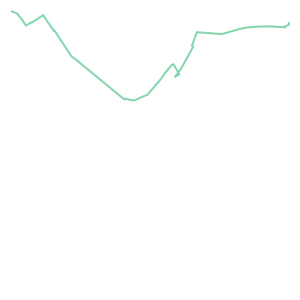

In [ ]:
# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

In [ ]:
route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (6.01e+05 5.12e+05, 6.01e+05 5.12e+...","[9435421106, 7730318309, 9435421189, 940966491...",2317.573048


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that
everything is ok by plotting our route on top of our street network and some
buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [ ]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Plot

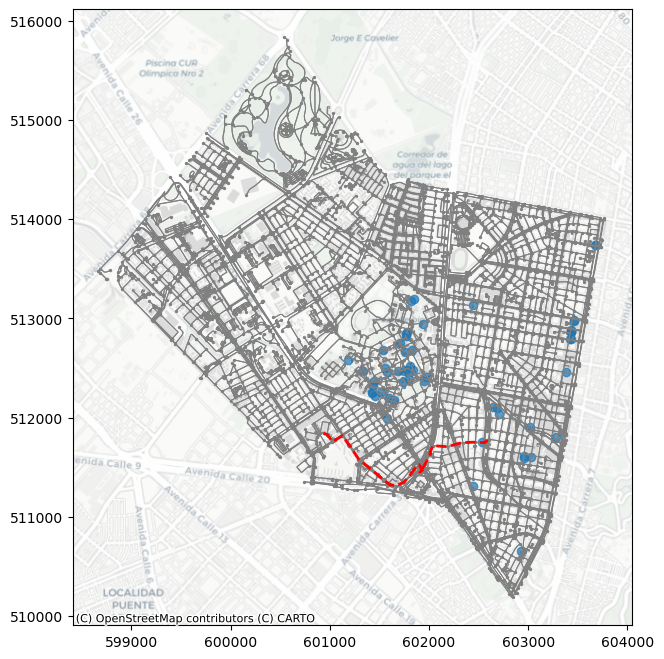

In [ ]:
fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

## Prepare data for saving to file

In [ ]:
edges.head()

osmid      highway lanes        name  oneway  \
u         v           key                                                    
253762003 500959293   0    24350411  residential     2  Carrera 24   False   
          7607115142  0    24350411  residential     2  Carrera 24   False   
          264153961   0    89574149  residential     2    Calle 27   False   
          500959410   0    89574149  residential     2    Calle 27   False   
500959293 10090985240 0    24350411  residential     2  Carrera 24   False   

                          reversed     length maxspeed  \
u         v           key                                
253762003 500959293   0      False  54.439641      NaN   
          7607115142  0       True  83.514286      NaN   
          264153961   0      False  91.009857       30   
          500959410   0       True  85.457771       30   
500959293 10090985240 0      False  47.759220      NaN   

                                                                    geometry  \
u         v           key                                                      
253762003 500959293   0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
          7607115142  0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
          264153961   0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
          500959410   0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   
500959293 10090985240 0    LINESTRING (6.02e+05 5.11e+05, 6.02e+05 5.11e+05)   

                          tunnel service bridge access width junction area  
u         v           key                                                   
253762003 500959293   0      NaN     NaN    NaN    NaN   NaN      NaN  NaN  
          7607115142  0      NaN     NaN    NaN    NaN   NaN      NaN  NaN  
          264153961   0      NaN     NaN    NaN    NaN   NaN      NaN  NaN  
          500959410   0      NaN     NaN    NaN    NaN   NaN      NaN  NaN  
500959293 10090985240 0      NaN     NaN    NaN    NaN   NaN      NaN  NaN

In [ ]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

Now we can see that most of the attributes are of type `object` that quite
often (such as ours here) refers to a string type of data.

## Save the data:

In [ ]:
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "notebooks/Taller3/data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

### 🚀 **Now it’s your turn! — Extending your analysis**

1. **Create** a 50 m buffer around the route and select buildings intersecting it.  
2. **Count** buildings both in total and by `building` tag within this corridor.  
3. **Export** the result to `buildings_along_route.geojson`.  

> 💡 Try `buildings[buildings.intersects(buffer)]` or a spatial overlay with GeoPandas.
